# Model training

In [1]:
import os
import random
import numpy as np
import pandas as pd
import pickle
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

print('Tensorflow: ', tf.__version__)
print('Opencv: ', cv2.__version__)

Tensorflow:  2.5.0
Opencv:  4.5.2


In [4]:
DATASET_PATH = '../dataset/'
CSV_PATH = '../'
MODELS_PATH = '../models/'
MODEL_NAME = 'bs_mobiletnet_model_gris'

In [5]:
label_df = pd.read_csv(os.path.join(CSV_PATH, 'bs_labels.csv'))
label_df.head(10)

,file_path,file_name,label,subset
0,wasp/1331787019_ca513a7acf_n.jpg,1331787019_ca513a7acf_n.jpg,wasp,train
1,bee/14322267704_2ac34a2af2_n.jpg,14322267704_2ac34a2af2_n.jpg,bee,train
2,wasp/7382817412_b5a0f8c899_w.jpg,7382817412_b5a0f8c899_w.jpg,wasp,train
3,wasp/4250759545_eb707b1145_n.jpg,4250759545_eb707b1145_n.jpg,wasp,train
4,other_insect/insect3.jpg,insect3.jpg,other_insect,train
5,other_insect/insect_image_204.jpg,insect_image_204.jpg,other_insect,train
6,other_insect/8542836797_477176edca_n.jpg,8542836797_477176edca_n.jpg,other_insect,train
7,bee/1324904081_75fdbb7ace_n.jpg,1324904081_75fdbb7ace_n.jpg,bee,train
8,bee/15063164899_4b3d4e7082_w.jpg,15063164899_4b3d4e7082_w.jpg,bee,train
9,wasp/6103665305_b52694b9a9_m.jpg,6103665305_b52694b9a9_m.jpg,wasp,train


In [6]:
train_df = label_df[label_df['subset'] == 'train']
val_df = label_df[label_df['subset'] == 'validation']
test_df = label_df[label_df['subset'] == 'test']

In [7]:
NUM_CLASSES = 4
TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 100

# Data augmentation

In [8]:
def gris(img):
    grey_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    rgb_img = np.repeat(grey_image[..., np.newaxis], 3, -1)
    return rgb_img
    


In [9]:
#aqui es donde va preprocess function
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=25,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.7, 1.3],
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=gris
                                  )
#aqui es donde va preprocess function
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=gris)


train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=DATASET_PATH, 
                                                    x_col='file_path',
                                                    y_col='label',
                                                    class_mode='categorical',
                                                    target_size=TARGET_SIZE,
                                                    seed=42,
                                                    batch_size=BATCH_SIZE)

val_generator = test_datagen.flow_from_dataframe(val_df,
                                                 directory=DATASET_PATH, 
                                                 x_col='file_path',
                                                 y_col='label',
                                                 class_mode='categorical',
                                                 target_size=TARGET_SIZE,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE)

Found 10122 validated image filenames belonging to 4 classes.
Found 1265 validated image filenames belonging to 4 classes.


# Model definition

In [10]:
input_ = Input(shape=(224, 224, 3))

base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_tensor=input_,
)

base_model.trainable = False

base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [11]:
# Descongelo las 6 últimas capas
for i in range(-6, 0):
    base_model.layers[i].trainable = True

In [12]:
# Compruebo que se han descongelado las capas que quiero
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name',
                              'Layer Trainable']).tail(10)

,Layer Type,Layer Name,Layer Trainable
76,<tensorflow.python.keras.layers.advanced_activ...,conv_dw_12_relu,False
77,<tensorflow.python.keras.layers.convolutional....,conv_pw_12,False
78,<tensorflow.python.keras.layers.normalization_...,conv_pw_12_bn,False
79,<tensorflow.python.keras.layers.advanced_activ...,conv_pw_12_relu,False
80,<tensorflow.python.keras.layers.convolutional....,conv_dw_13,True
81,<tensorflow.python.keras.layers.normalization_...,conv_dw_13_bn,True
82,<tensorflow.python.keras.layers.advanced_activ...,conv_dw_13_relu,True
83,<tensorflow.python.keras.layers.convolutional....,conv_pw_13,True
84,<tensorflow.python.keras.layers.normalization_...,conv_pw_13_bn,True
85,<tensorflow.python.keras.layers.advanced_activ...,conv_pw_13_relu,True


In [13]:
custom_model = base_model.output
custom_model = GlobalAveragePooling2D()(custom_model)
custom_model = Dense(1024, activation='relu')(custom_model)
custom_model = Dropout(0.2)(custom_model)
custom_model = Dense(512, activation='relu')(custom_model)
custom_model = Dropout(0.2)(custom_model)
custom_model = Dense(128, activation='relu')(custom_model)
custom_model = Dropout(0.2)(custom_model)
custom_model = Dense(NUM_CLASSES, activation='softmax')(custom_model)

model = Model(base_model.input, custom_model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

# Fitting optimization

In [14]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=15,
                   restore_best_weights=True)

mc = ModelCheckpoint(filepath='bs_mobile-gris_model.h5',
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True)

lr_start = 0.001
lr_decay = 0.9
lrs = LearningRateScheduler(lambda epoch: lr_start * np.power(lr_decay, epoch))

# Fit model

In [15]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // BATCH_SIZE,
                    callbacks=[es, mc, lrs])

Epoch 1/100
158/158 [==============================] - 1125s 7s/step - loss: 0.6104 - accuracy: 0.7637 - val_loss: 0.6845 - val_accuracy: 0.7640
Epoch 2/100
158/158 [==============================] - 1063s 7s/step - loss: 0.4160 - accuracy: 0.8522 - val_loss: 1.0058 - val_accuracy: 0.7196
Epoch 3/100
158/158 [==============================] - 1049s 7s/step - loss: 0.3560 - accuracy: 0.8723 - val_loss: 0.5788 - val_accuracy: 0.8141
Epoch 4/100
158/158 [==============================] - 1042s 7s/step - loss: 0.3027 - accuracy: 0.8920 - val_loss: 0.3835 - val_accuracy: 0.8775
Epoch 5/100
158/158 [==============================] - 1021s 6s/step - loss: 0.2823 - accuracy: 0.8963 - val_loss: 0.3506 - val_accuracy: 0.8890
Epoch 6/100
158/158 [==============================] - 1063s 7s/step - loss: 0.2382 - accuracy: 0.9151 - val_loss: 0.5709 - val_accuracy: 0.8339
Epoch 7/100
158/158 [==============================] - 1070s 7s/step - loss: 0.2294 - accuracy: 0.9169 - val_loss: 0.4751 - val_ac

# Model history

In [16]:
model.save(MODEL_NAME + '.h5')

In [32]:
with open(MODELS_PATH + MODEL_NAME + '_hist', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [33]:
history = pickle.load(open(MODELS_PATH + MODEL_NAME + '_hist', "rb"))

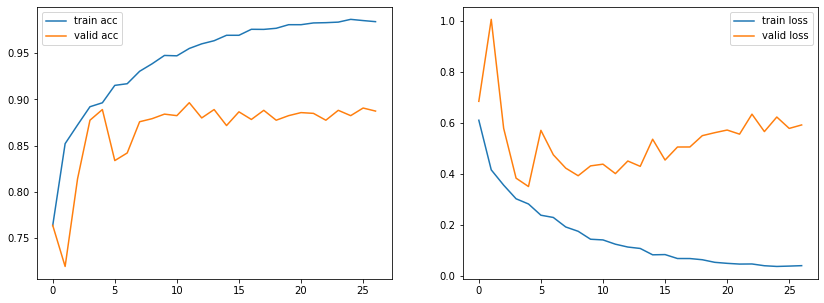

In [34]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend()

plt.show()